# Iterative Closest Point (ICP)

In [75]:
# imports
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

## Implementation

In [76]:
import icp.icp as other_icp # Import OK

## Data setup

2D Translation & Rotation matrix:
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & t_x \\
\sin(\theta) & \cos(\theta) & t_y \\
0 & 0 & 1 \\
\end{bmatrix}
$$

### Rigid transformation

In [77]:
def randomTransformation2D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 2D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((3, 3), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180
    M[0:2, 0:2] = np.array([[np.cos(angle), -np.sin(angle)],
                              [np.sin(angle), np.cos(angle)]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(2), maxTrans / np.sqrt(2), size=2)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:2, 2] = translation
    M[2, 2] = 1

    return M

randomTransformation2D()

array([[ 0.95659855,  0.29140902, -0.01915793],
       [-0.29140902,  0.95659855, -0.54575292],
       [ 0.        ,  0.        ,  1.        ]])

3D rotation matrix:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a6821937d5031de282a190f75312353c970aa2df)

Therefore, the **3D translation & rotation matrix** looks like:

If rotation on `z axis`
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & t_x\\
\sin(\theta) & \cos(\theta) & 0 & t_y\\
0 & 0 & 1 & t_z\\
0 & 0 & 0 & 1
\end{bmatrix}

In [78]:
def randomTransformation3D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 3D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((4, 4), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180

    # FIXME: random axis rotation
    M[0:3, 0:3] = np.array([[np.cos(angle), -np.sin(angle), 0],
                            [np.sin(angle), np.cos(angle), 0],
                            [0, 0, 1]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(3), maxTrans / np.sqrt(3), size=3)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:3, -1] = translation
    M[-1, -1] = 1

    return M

randomTransformation3D()

array([[ 0.95774174, -0.28762955,  0.        , -0.09047296],
       [ 0.28762955,  0.95774174,  0.        , -0.57167364],
       [ 0.        ,  0.        ,  1.        , -0.46971172],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Uniforme 2D square

In [79]:
def generate_uniform_2d_square(width:float, nb_points_edge:int) -> np.array:
    """
    Generate uniform 2D square with homogeneous points on the edges

    Parameters
    ----------
    width : float
        Size of the square
    nb_points_edge:
        Number of points on each edge

    Returns
    -------
    square_2d : np.array
        Generated uniform 2D square with shape (nb_points_edge * 4, 3)
    """

    edge_points = np.linspace(-width/2, width/2, nb_points_edge)
    # top: x axis different, y = width / 2
    edges_points_2d = np.expand_dims(edge_points, axis=-1)
    top = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), width / 2)), axis=-1)
    # bottom: x axis different, y = -width / 2
    bottom = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), -width / 2)), axis=-1)
    # left: x = -width / 2, y axis different
    left = np.concatenate((np.full((len(edge_points), 1), -width / 2), edges_points_2d), axis=-1)
    # right: x = width / 2, y axis different
    right = np.concatenate((np.full((len(edge_points), 1), width / 2), edges_points_2d), axis=-1)
    # Stack all the points
    points = np.vstack((top, bottom, left, right))
    # Homogenous points
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points


In [80]:
square_width = 1
square_2d = generate_uniform_2d_square(width=square_width, nb_points_edge=10)
square_2d.shape, square_2d.dtype

((40, 3), dtype('float64'))

Text(0.5, 1.0, '2D Square')

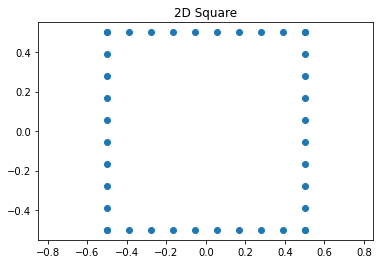

In [81]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.axis('equal')
plt.title("2D Square")

In [82]:
M_uniform_square = randomTransformation2D(maxRot=20, maxTrans=1)
print("Rotation & translation matrix: ", M_uniform_square.shape), print(M_uniform_square),
print("Square 2D shape: ", square_2d.shape)
# Rotate and translate basic square
square_2d_transformed = square_2d @ M_uniform_square.T # FIXME: what it does not work with no transpose...

Rotation & translation matrix:  (3, 3)
[[ 0.99826491 -0.05888271  0.4597974 ]
 [ 0.05888271  0.99826491 -0.06396376]
 [ 0.          0.          1.        ]]
Square 2D shape:  (40, 3)


Text(0.5, 1.0, '2D Square with rotation')

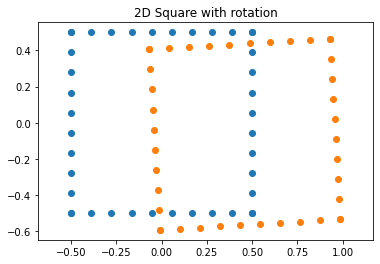

In [83]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.scatter(square_2d_transformed[:, 0], square_2d_transformed[:, 1])
plt.axis('equal')
plt.title("2D Square with rotation")

### Non uniform 2D square

In [84]:
def generate_random_2d_square(width, min_side_points=10, max_side_points=20):
    """
    Generate random 2D square with homogeneous points on the edges

    Parameters
    ----------
    width : float
        Size of the square
    min_edge_points:
        Minimum number of points on each edge
    max_edge_points:
        Maximum number of points on each edge

    Returns
    -------
    square_2d : np.array
        Generated random 2D square with shape (M, 3)
        with M in [4 * min_side_points, 4 * max_side_points]
    """
    # Similar to generate_uniform_2d_square
    # Returns number of points for the 4 sides
    nb_edge_points = np.random.randint(min_side_points, max_side_points, 4)

    # Compute random number between [0, 1], multiply by the width to distribute over the width
    # And substract width / 2 to center the points
    points = np.random.random_sample(nb_edge_points[0]) * width - width / 2
    top = np.concatenate((np.expand_dims(points, axis=-1), np.full((len(points), 1), width / 2)), axis=1)

    points = np.random.random_sample(nb_edge_points[1]) * width - width / 2
    bottom = np.concatenate((np.expand_dims(points, axis=-1), np.full((len(points), 1), -width / 2)), axis=1)

    points = np.random.random_sample(nb_edge_points[2]) * width - width / 2
    left = np.concatenate((np.full((len(points), 1), -width / 2), np.expand_dims(points, axis=-1)), axis=1)

    points = np.random.random_sample(nb_edge_points[3]) * width - width / 2
    right = np.concatenate((np.full((len(points), 1), width / 2), np.expand_dims(points, axis=-1)), axis=1)

    points = np.concatenate((top, bottom, left, right), axis=0)
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points

In [85]:
random_square_2d = generate_random_2d_square(width=1)
# /!\ Not the same number of points
random_square_2d_transformed = generate_random_2d_square(width=1)
M_random_square = randomTransformation2D(maxRot=25)
random_square_2d_transformed = random_square_2d_transformed @ M_random_square.T

Text(0.5, 1.0, 'Random 2D Squares')

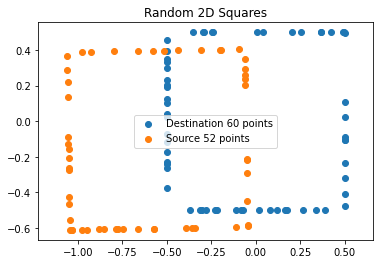

In [86]:
plt.scatter(random_square_2d[:, 0], random_square_2d[:, 1],
            label=f"Destination {len(random_square_2d)} points")
plt.scatter(random_square_2d_transformed[:, 0], random_square_2d_transformed[:, 1],
            label=f"Source {len(random_square_2d_transformed)} points")
plt.axis('equal')
plt.legend(loc='best')
plt.title("Random 2D Squares")

### Non uniform 3D cube

In [87]:
def generate_3d_cube(width:float, min_face_points: int=500, max_face_points: int=750) -> np.array:
    """
    Generate 3D cube with homogeneous points

    Parameters
    ----------
    width : float
        Size of the square
    min_face_points: int
        Minimum number of points on each face
    max_face_points: int
        Maximum number of points on each face

    Returns
    -------
    cube_3d : np.array
        Generated 3D cube with shape (M, 4)
        with M in [3 (axis) * 2 (nb_face_per_axis) * min_face_points,
                   3 (axis) * 2 (nb_face_per_axis) * max_face_points]
    """

    def generate_random_face_points(width, min_face_points, max_face_points):
        nb_points_face = np.random.randint(min_face_points, max_face_points, 1)[0]

        x_points = np.random.random_sample(nb_points_face) * width - width / 2
        y_points = np.random.random_sample(nb_points_face) * width - width / 2

        return np.concatenate((np.expand_dims(x_points, axis=-1), np.expand_dims(y_points, axis=-1)), axis=1)

    # There are 3 axis
    # 2 faces for each axis
    faces = []
    for axis in range(3):
        face = generate_random_face_points(width, min_face_points, max_face_points)
        # On a face, there are 3 coordinates
        # 2 coordinates are generated randomly
        # 3rd coordinates is constant and equals +- width / 2
        faces.append(np.insert(face, axis, np.full(face.shape[0], -width / 2), axis=1))

        face = generate_random_face_points(width, min_face_points, max_face_points)
        faces.append(np.insert(face, axis, np.full(face.shape[0], width / 2), axis=1))

    points = np.concatenate(faces, axis=0)
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    assert len(points) >= min_face_points * 3 * 2 and len(points) <= max_face_points * 3 * 2
    return points

In [88]:
random_cube_3d = generate_3d_cube(width=1)
random_cube_3d_transformed = generate_3d_cube(width=1)
M_random_cube = randomTransformation3D(maxRot=25)
random_cube_3d_transformed = random_cube_3d_transformed @ M_random_cube.T
random_cube_3d.shape, random_cube_3d_transformed.shape

((3534, 4), (3729, 4))

In [89]:
# Width matplotlib (no interaction)
# ax = fig.add_subplot(1, 1, 1, projection="3d")
# ax.scatter(, random_cube_3d[:, 1], random_cube_3d[:, 2])
# ax.scatter(random_cube_3d_transformed[:, 0], random_cube_3d_transformed[:, 1], random_cube_3d_transformed[:, 2])

# Configure the trace.
trace_source = go.Scatter3d(
    x=random_cube_3d_transformed[:, 0],
    y=random_cube_3d_transformed[:, 1],
    z=random_cube_3d_transformed[:, 2],
    mode='markers',
    marker={
        'size': 2,
    },
    name="source"
)
trace_destination = go.Scatter3d(
    x=random_cube_3d[:, 0],
    y=random_cube_3d[:, 1],
    z=random_cube_3d[:, 2],
    mode='markers',
    marker={
        'size': 2,
    },
    name="destination"
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace_destination, trace_source]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

## Test

### Uniform 2D square

Apply `nearest_neighbor` function over the two squared and visualize the square

In [90]:
distances, indices_dst = other_icp.nearest_neighbor(square_2d_transformed, square_2d)
indices_dst

array([ 4,  5,  6,  7,  8, 38,  9,  9,  9,  9, 14, 15, 16, 17, 18, 19, 19,
       19, 19, 19, 14, 14, 14, 14, 14, 24,  4,  4,  4,  4, 19, 31, 32, 33,
       34, 35, 36, 37, 38,  9])

In [91]:
def plot_pairing(source, destination, ax=None, title=None):
    title_func = plt.title
    if ax is None:
        ax = plt
    else:
        title_func = ax.set_title

    _, indices_dst = other_icp.nearest_neighbor(source, destination)
    ax.scatter(destination[:, 0], destination[:, 1])
    ax.scatter(source[:, 0], source[:, 1])
    ax.plot(np.vstack((destination[indices_dst][:, 0], source[:, 0])),
            np.vstack((destination[indices_dst][:, 1], source[:, 1])), color='green')
    ax.axis('equal')
    if title:
        title_func(title)

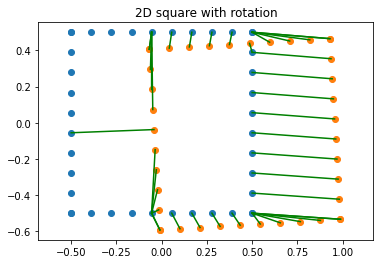

In [92]:
plot_pairing(square_2d_transformed, square_2d, title="2D square with rotation")

**Comments**:
* Some of the source points are paired to the same destination points (i.e left 3 source (orange) points are paired to 1 destination (blue) points)
* All the source points have at least/at most one destination pair.

In [93]:
# the function expects non homogeneous coordinates
T, distances, nb_iteration = other_icp.icp(square_2d_transformed[:, :-1], square_2d[:, :-1], M_uniform_square, max_iterations=20)
print(T.shape, distances.shape, nb_iteration)
print((square_2d_transformed @ T.T).shape)

(3, 3) (40,) 6
(40, 3)


In [94]:
def plot_distance_error(distances, title=None, ax=None):
    title_func = plt.title
    if ax is None:
        ax = plt
    else:
        title_func = ax.set_title

    ax.scatter(range(len(distances)), distances)
    ax.stem(range(len(distances)), distances, linefmt='r')
    mean_distances = np.mean(distances)
    ax.plot(np.full(len(distances), mean_distances), linestyle="dotted", color='orange')
    ax.set_ylim(0, 1)
    ax.text(len(distances) - 0.5 * len(distances), 0.8, "mean: {:.2f}".format(mean_distances))
    if title is not None:
        title_func(title)

In [95]:
def plot_icp_progress(source, destination, init_M=None, max_iterations=10, icp_implem=other_icp):
    fig, ax = plt.subplots(nrows=max_iterations-1, ncols=2, figsize = (15, 30))
    source_cpy = source.copy()

    errors = []

    for iter in range(1, max_iterations):
        T, distances, nb_iteration = icp_implem.icp(source_cpy[:, :-1], destination[:, :-1], init_M, max_iterations=iter, tolerance=0.00001)
        source_cpy = source_cpy @ T.T
        errors.append(np.mean(distances))
        plot_pairing(source_cpy, destination, ax=ax[iter-1, 0])
        plot_distance_error(distances, title=f"Pairing errors after {nb_iteration} iteration", ax=ax[iter-1, 1])

    fig, ax = plt.subplots(1, figsize=(15, 5))
    ax.set_title("Errors over iterations")
    ax.plot(range(1, len(errors)+1), errors)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Mean distances error")
    ax.set_xlim(1, len(errors))
    plt.show()

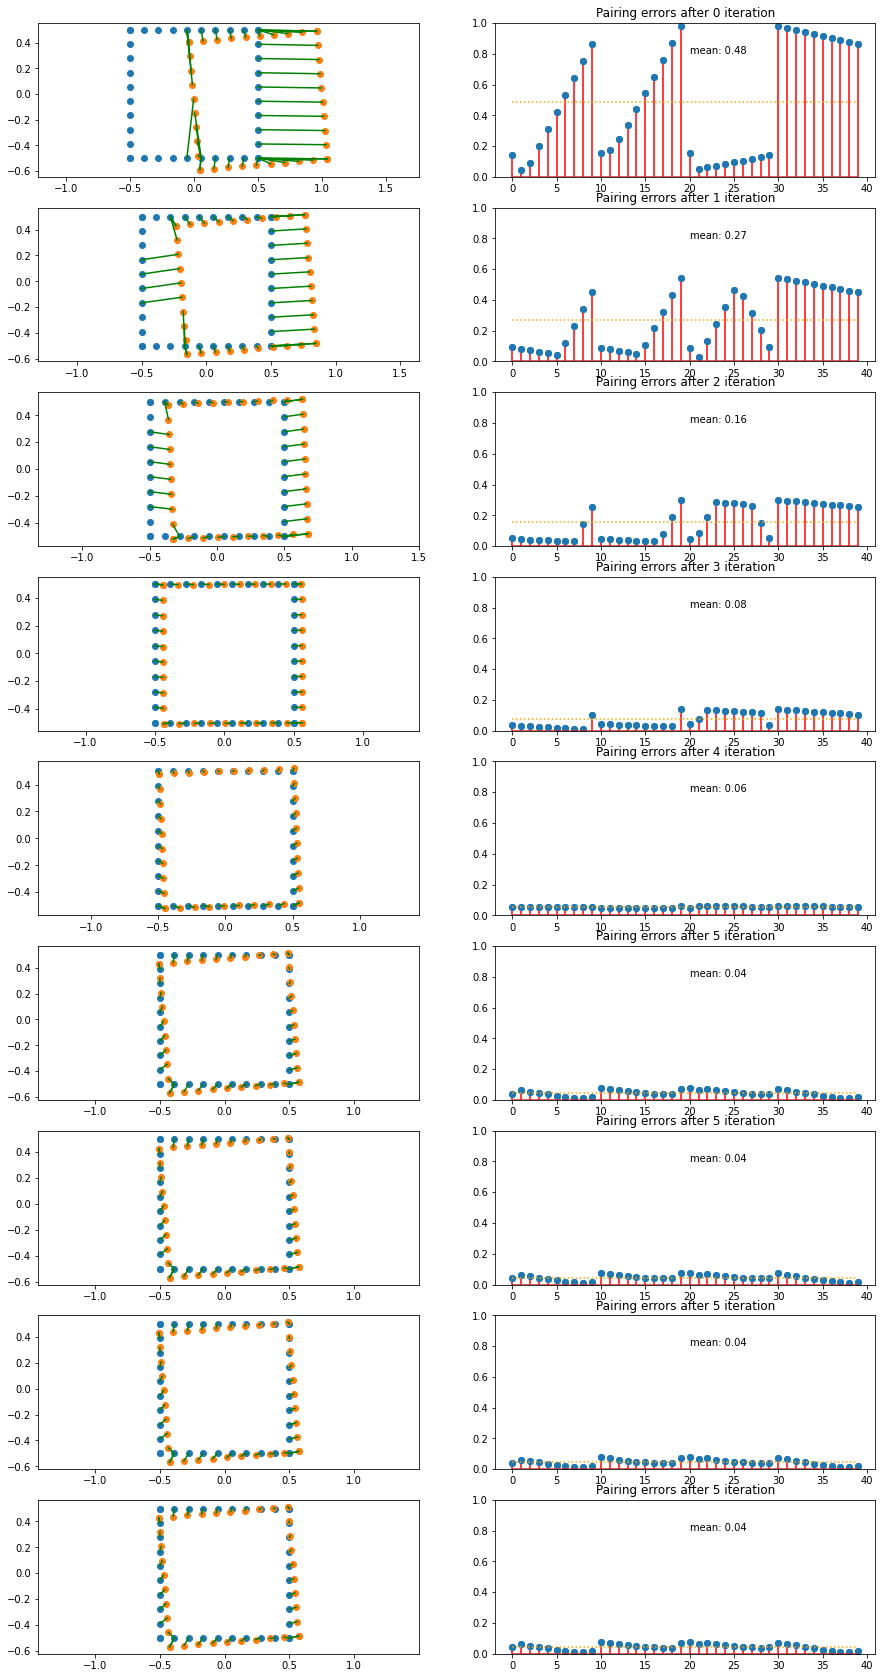

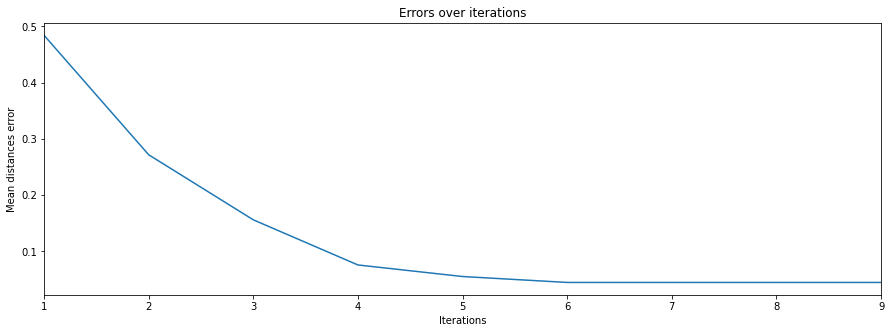

In [96]:
plot_icp_progress(square_2d_transformed, square_2d, M_uniform_square, max_iterations=10)

**Comments**:
* The ICP converge to the solution after 6 iterations
* But it seems it stops before the registration is totally correct even with a very low tolerance
* Output: not fully registred

### Random 2D square

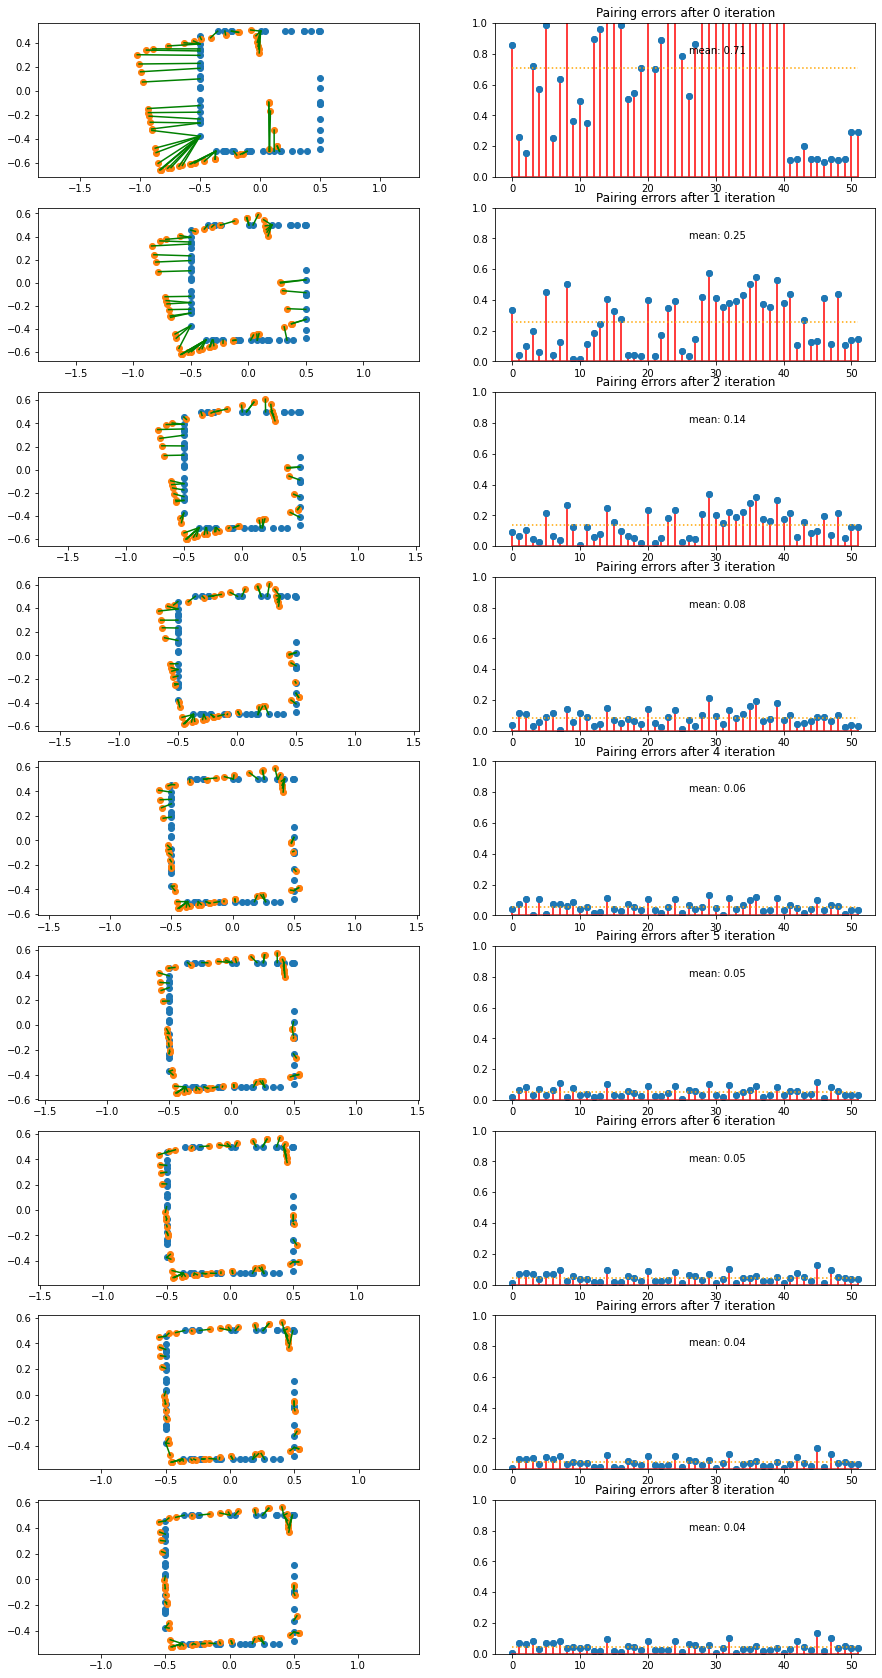

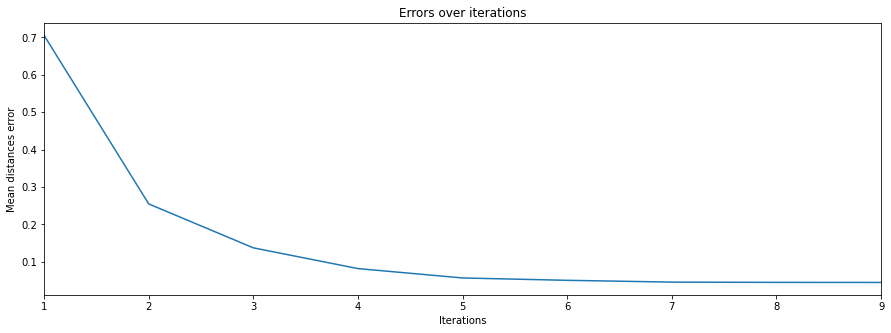

In [97]:
plot_icp_progress(random_square_2d_transformed, random_square_2d, M_random_square, max_iterations=10)

### Random 3D cube

## Variants